# CMS 2020 - Looking for Potential Problem Nodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline

import csv
from os import path
from pathlib import Path

root_dir = Path().absolute()

In [2]:
# pre-cleaned dataset (all accounts)

accre_jobs_cleaned = pd.read_csv('../data/accre_jobs_cleaned.csv')
accre_jobs_cleaned

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,...,0,65973.49,2748.895417,NaN,122880.0,5120.0,5120.0,"('cn', '1531')",cn,1531
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,...,0,67181.12,2799.213333,NaN,122880.0,5120.0,5120.0,"('cn', '1441')",cn,1441
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,...,0,69111.86,2879.660833,NaN,122880.0,5120.0,5120.0,"('cn', '1464')",cn,1464
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,...,0,65317.33,2721.555417,NaN,122880.0,5120.0,5120.0,"('cn', '1473')",cn,1473
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,...,0,65876.11,2744.837917,NaN,122880.0,5120.0,5120.0,"('cn', '1440')",cn,1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813177,24173815_6,portabella,vennie,32768Mn,23269.08M,1-00:00:00,00:01:36,1,2,production,...,0,23269.08,11634.540000,NaN,32768.0,16384.0,16384.0,"('cn', '432')",cn,432
3813178,24173815_7,portabella,vennie,32768Mn,20879.81M,1-00:00:00,00:01:37,1,2,production,...,0,20879.81,10439.905000,NaN,32768.0,16384.0,16384.0,"('cn', '440')",cn,440
3813179,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,...,0,30042.68,15021.340000,NaN,32768.0,16384.0,16384.0,"('cn', '312')",cn,312
3813180,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,...,0,31067.75,15533.875000,NaN,32768.0,16384.0,16384.0,"('cn', '312')",cn,312


In [3]:
accre_jobs_cleaned.shape

(3813182, 24)

In [4]:
def convert_time_to_seconds(time_str):
    """Convert the given time string d-hh:mm:ss or hh:mm:ss to total seconds."""
    
    # Account for possible errors
    try:
        
        # Initialize all time components to 0
        days = hours = minutes = seconds = 0

        # Split the time string at the dash mark
        time_dash_split = time_str.split("-") # => Either ["d", "hh:mm:ss"] or ["hh:mm:ss"]

        # Assign each time element to variables
        if len(time_dash_split) > 1: 
            # Remove the first element from the list and convert to integer and add to days
            days += int(time_dash_split.pop(0))

        # If here, len(time_dash_split) == 1
        # Split the time at the colon marks
        time_colon_split = time_dash_split[0].split(":") # => ["hh", "mm", "ss"]
        seconds += int(time_colon_split.pop())
        minutes += int(time_colon_split.pop())
        hours += int(time_colon_split.pop())

        # Now combine everything together
        return (((((days * 24) + hours) * 60) + minutes) * 60) + seconds
        
    except AttributeError as error:
        # Skip everything if the column is already in seconds (assuming one single digit)
        return time_str

In [5]:
# Apply time conversion
new_reqtime = accre_jobs_cleaned["reqtime"].map(convert_time_to_seconds)
new_usedtime = accre_jobs_cleaned["usedtime"].map(convert_time_to_seconds)

# Assign the values to the columns
accre_jobs_cleaned = accre_jobs_cleaned.assign(reqtime = new_reqtime)
accre_jobs_cleaned = accre_jobs_cleaned.assign(usedtime = new_usedtime)

# Check
accre_jobs_cleaned.head()

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
0,15925210,treviso,arabella,122880Mn,65973.49M,1188000,1188028,1,24,production,...,0,65973.49,2748.895417,NaN,122880.0,5120.0,5120.0,"('cn', '1531')",cn,1531
1,15861126,treviso,arabella,122880Mn,67181.12M,1188000,1090256,1,24,production,...,0,67181.12,2799.213333,NaN,122880.0,5120.0,5120.0,"('cn', '1441')",cn,1441
2,15861125,treviso,arabella,122880Mn,69111.86M,1188000,1188020,1,24,production,...,0,69111.86,2879.660833,NaN,122880.0,5120.0,5120.0,"('cn', '1464')",cn,1464
3,16251645,treviso,arabella,122880Mn,65317.33M,1188000,1050632,1,24,production,...,0,65317.33,2721.555417,NaN,122880.0,5120.0,5120.0,"('cn', '1473')",cn,1473
4,16251646,treviso,arabella,122880Mn,65876.11M,1188000,1188003,1,24,production,...,0,65876.11,2744.837917,NaN,122880.0,5120.0,5120.0,"('cn', '1440')",cn,1440


# Create CMS dataframe

In [6]:
cms_jobs = accre_jobs_cleaned[accre_jobs_cleaned['account'].str.contains('cms')]
cms_jobs

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
2125,17032244,cms,cmspilot,28000Mn,8320.07M,172800,171106,1,4,production,...,0,8320.07,2080.0175,NaN,28000.0,7000.000,7000.000,"('cn', '1205')",cn,1205
2126,17032568,cms,cmspilot,28000Mn,11954.84M,172800,171193,1,4,production,...,0,11954.84,2988.7100,NaN,28000.0,7000.000,7000.000,"('cn', '1492')",cn,1492
2127,17032569,cms,cmspilot,28000Mn,10498.84M,172800,171396,1,4,production,...,0,10498.84,2624.7100,NaN,28000.0,7000.000,7000.000,"('cn', '1497')",cn,1497
2128,17032916,cms,cmspilot,21875Mn,11728.02M,172800,170875,1,8,nogpfs,...,0,11728.02,1466.0025,NaN,21875.0,2734.375,2734.375,"('ng', '1037')",ng,1037
2129,17032920,cms,cmspilot,94451Mn,20659.08M,172800,170164,1,8,nogpfs,...,0,20659.08,2582.3850,NaN,94451.0,11806.375,11806.375,"('ng', '691')",ng,691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813137,24173661,cmsadmin,autocms,4096Mc,860.03M,43200,230,1,1,production,...,0,860.03,860.0300,4096.0,NaN,4096.000,4096.000,"('cn', '394')",cn,394
3813138,24173686,cmsadmin,lcgadmin,2000Mn,0.09M,172800,149,1,1,sam,...,0,0.09,0.0900,NaN,2000.0,2000.000,2000.000,"('generic', 'vm-cms-sam-pri')",generic,vm-cms-sam-pri
3813149,24173689,cmsadmin,lcgadmin,2000Mn,0.09M,172800,131,1,1,sam,...,0,0.09,0.0900,NaN,2000.0,2000.000,2000.000,"('generic', 'vm-cms-sam-sec')",generic,vm-cms-sam-sec
3813150,24173711,cmsadmin,lcgadmin,2000Mn,0.09M,172800,89,1,1,sam,...,0,0.09,0.0900,NaN,2000.0,2000.000,2000.000,"('generic', 'vm-cms-sam-pri')",generic,vm-cms-sam-pri


In [48]:
cms_jobs = cms_jobs[(cms_jobs['partition'] == 'production') | (cms_jobs['partition'] == 'nogpfs')]

In [49]:
cms_jobs['partition'].value_counts()

production    649572
nogpfs        310405
Name: partition, dtype: int64

In [50]:
cms_jobs['account'].value_counts()

cms            800857
cms_lowprio    135682
cmsadmin        23438
Name: account, dtype: int64

In [51]:
cms_jobs['user'].value_counts()

cmslocal      491240
cmspilot      343555
uscmslocal     45691
c19pilot       45688
autocms        23438
tamekia         6813
erick           1816
meghann          602
lailah           410
magen            400
tomasa           175
tremaine          51
lavern            42
lcgadmin          26
benjamine         25
vannie             2
clemens            2
minor              1
Name: user, dtype: int64

In [52]:
cms_auto = cms_jobs[(cms_jobs['user'] == 'cmslocal') | (cms_jobs['user'] == 'cmspilot')]
cms_auto['user'].value_counts()

cmslocal    491240
cmspilot    343555
Name: user, dtype: int64

In [53]:
cms_auto = cms_auto[['reqtime','usedtime','reqmem_mn','used_mb_per_node','cluster_type','cluster_nodes','nodes','exitcode_error','state']]
cms_auto

,reqtime,usedtime,reqmem_mn,used_mb_per_node,cluster_type,cluster_nodes,nodes,exitcode_error,state
2125,172800,171106,28000.0,8320.07,cn,1205,1,0,COMPLETED
2126,172800,171193,28000.0,11954.84,cn,1492,1,0,COMPLETED
2127,172800,171396,28000.0,10498.84,cn,1497,1,0,COMPLETED
2128,172800,170875,21875.0,11728.02,ng,1037,1,0,COMPLETED
2129,172800,170164,94451.0,20659.08,ng,691,1,0,COMPLETED
...,...,...,...,...,...,...,...,...,...
3812800,172800,86,28000.0,20.39,cn,1471,1,0,COMPLETED
3812801,172800,79,28000.0,6.24,cn,1471,1,0,COMPLETED
3812802,172800,79,28000.0,6.23,cn,1534,1,0,COMPLETED
3812856,172800,60,21875.0,6.23,ng,1080,1,0,COMPLETED


In [54]:
cms_jobs['exitcode_error'].value_counts()

0      959933
9          43
125         1
Name: exitcode_error, dtype: int64

In [55]:
cms_auto['nodes'].value_counts()

1    834795
Name: nodes, dtype: int64

In [56]:
cms_auto_sample1000 = cms_auto.sample(n=1000)

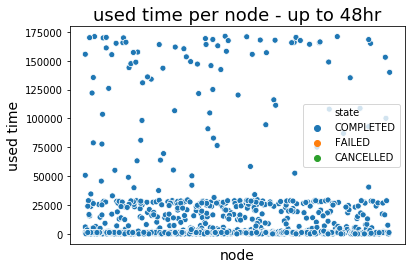

In [71]:
sns.scatterplot(data = cms_auto_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'state');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 48hr', size=18)
plt.xticks([]);

In [58]:
cms_auto_10hr_sample1000 = cms_auto[cms_auto['usedtime'] > 36000].sample(n = 1000)
cms_auto_10hr_sample1000.sort_values(by = cms_auto_10hr_sample1000['usedtime'], ascending = False)

KeyError: 2078319    170918
1985603    121454
150724     166678
452785      55078
1783627    161614
            ...  
79561      152652
2649778    143871
2448696    116797
2420570     63849
2501345    136447
Name: usedtime, Length: 1000, dtype: int64

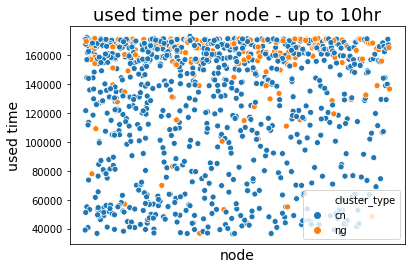

In [72]:
sns.scatterplot(data = cms_auto_10hr_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 10hr', size=18)
plt.xticks([]);

In [60]:
cms_auto_1hr_sample1000 = cms_auto[cms_auto['usedtime'] > 3600].sample(n = 1000)

,reqtime,usedtime,reqmem_mn,used_mb_per_node,cluster_type,cluster_nodes,nodes,exitcode_error,state
1854812,172800,22516,5000.0,2413.96,cn,1488,1,0,COMPLETED
2934134,172800,27671,28000.0,7753.32,cn,478,1,0,COMPLETED
2301561,172800,170277,186648.0,72436.75,cn,1543,1,0,COMPLETED
2172384,172800,20382,5000.0,1690.44,cn,1095,1,0,COMPLETED
2497293,172800,27663,28000.0,6779.94,cn,1282,1,0,COMPLETED
...,...,...,...,...,...,...,...,...,...
2385810,172800,145349,5000.0,3482.54,cn,1349,1,0,COMPLETED
2285432,172800,167062,46066.0,0.09,ng,1051,1,0,COMPLETED
2409027,172800,23548,5000.0,2659.80,cn,1293,1,0,COMPLETED
3064306,172800,9504,28000.0,20639.65,cn,454,1,0,COMPLETED


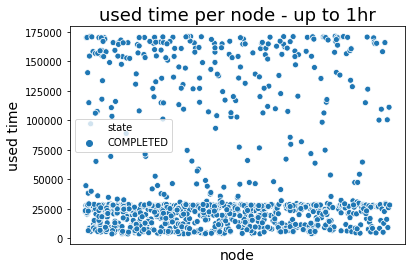

In [73]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'state');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 1hr', size=18)
plt.xticks([]);

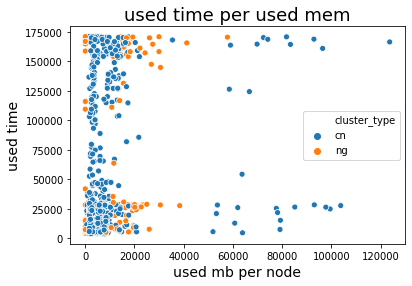

In [62]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'used_mb_per_node', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('used mb per node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per used mem', size=18);

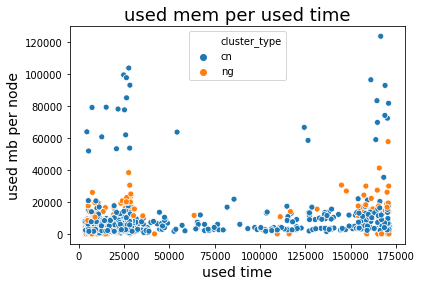

In [63]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('used mem per used time', size=18);

not interested in failed

cms_auto_failed = cms_auto[cms_auto['state'] == 'FAILED']

sns.scatterplot(data = cms_auto_failed, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('failed - used mem per used time', size=18);

cms_failed_1hr = cms_auto_failed[~cms_auto_failed['usedtime'].str.contains('-')]
cms_failed_1hr = cms_failed_1hr[cms_failed_1hr['usedtime'].str.contains('00.??.??')]
cms_failed_1hr

sns.scatterplot(data = cms_failed_1hr, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('failed 1 hour - used mem per used time', size=18);

sns.scatterplot(data = cms_failed_1hr, x = 'cluster_nodes', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('cluster nodes', size = 14)
plt.ylabel('used time', size = 14)
plt.title('failed 1 hour - used time per nodes', size=18);

cms_failed_1hr['cluster_nodes'].value_counts()

# Questions?